In [1]:
import numpy as np
import matplotlib as plt
from numba import njit
from numpy.typing import NDArray
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from util import normalize_values, ideal_point_method, linear_convolution

In [2]:
@njit
def get_system_size(n: int, N: int):
    return n * (N + 2)

In [3]:
@njit
def get_transition_intensity_matrix(
    n: int, 
    N: int,
    lambda_val: float,
    mu: float,
    gamma: float
) -> NDArray:
  size = get_system_size(n, N)
  transition_intensity_matrix = np.zeros((size, size))

  for row in range(size):
    for column in range(size):
      i = column // n
      j = column % n
      
      if row == column:
        continue
      
      if j <= n - 2 or n == 1:
        value = lambda_val
        transition_intensity_matrix[i * n + j][i * n + j + 1] = value
      elif j == n - 1 and i <= N:
        value = lambda_val
        transition_intensity_matrix[i * n + j][(i + 1) * n + 0] = value
      elif j == n - 1 and i == N + 1:
        value = lambda_val
        transition_intensity_matrix[i * n + j][i * n + 0] = value    
        
      if i >= 1:
        value = (i - 1) * gamma + mu
        transition_intensity_matrix[i * n + j][(i - 1) * n + j] = value
    
  for row in range(size):
    transition_intensity_matrix[row][row] = - np.sum(transition_intensity_matrix[row])
    
  return transition_intensity_matrix

In [4]:
def solve_global_balance_equation(
    Q: NDArray[NDArray[float]],
    n: int,
    N: int
) -> NDArray[float]:
    size = get_system_size(n, N)

    system = np.transpose(Q)
    norm_equation = np.ones(size)
    system = np.delete(system, 0, axis=0)
    system = np.vstack([system, norm_equation])

    b = np.zeros(size)
    b[-1] = 1

    q = np.linalg.solve(system, b)

    return q

In [5]:
@njit(fastmath=True)
def get_num_is_system(
    q: NDArray[float],
    n: int,
    N: int,
) -> float:
    num_in_system = 0
    for i in range(N + 2):
        for j in range(n):
            num_in_system += i * q[i * n + j]
            
    return num_in_system

@njit(fastmath=True)
def get_probability_of_loss(
    q: NDArray[float],
    n: int,
    N: int,
    lambda_val: float,
    gamma: float,
) -> float:
    probability = 0
    for j in range(n):
        num_in_queue = 0
        for i in range(1, N + 1):
            num_in_queue += i * q[(i + 1) * n + j]
            
        reject_probability = q[(N + 1) * n + j]
        probability += ((gamma / lambda_val) * num_in_queue) + reject_probability
    
    return probability

In [6]:
def get_statistics(
    n: int,
    N: int,
    lambda_val: float,
    mu: float,
    gamma: float
) -> (float, float):
    Q = get_transition_intensity_matrix(n, N, lambda_val, mu, gamma)
    q = solve_global_balance_equation(Q, n, N)
    
    probability_of_loss = get_probability_of_loss(q, n, N, lambda_val, gamma)
    # probability_of_loss = np.load('./round-robin/loss_probabilities.npy')[n - 1]
    num_in_system = get_num_is_system(q, n, N)

    response_time = num_in_system / (lambda_val * (1 - probability_of_loss))

    return response_time, probability_of_loss

In [7]:
p = 0.95
lambda_val = 1 / 0.299
mu = 1 / (37.69 * p)
gamma = 1 / 510

In [8]:
MAX_SERVERS = 20
MIN_SERVERS = 1

max_size_queue = 100

servers_num = np.arange(MIN_SERVERS, MAX_SERVERS + 1)

response_times = np.empty(0)
loss_probabilities = np.empty(0)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    response_time, probability_of_loss = get_statistics(
        i,
        max_size_queue,
        lambda_val,
        mu,
        gamma
    )
    response_times = np.append(response_times, response_time)
    # loss_probabilities = np.load('./round-robin/loss_probabilities.npy')
    loss_probabilities = np.append(loss_probabilities, probability_of_loss)
    

# with open('analytical_round_robin_response_times.npy', 'wb') as f:
#     np.save(f, response_times)

# with open('analytical_round_robin_probability_of_loss.npy', 'wb') as f:
#     np.save(f, loss_probabilities)

  0%|          | 0/20 [00:00<?, ?it/s]

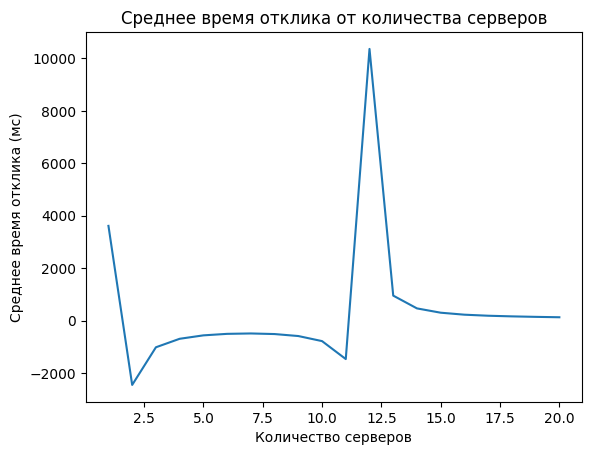

In [9]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Среднее время отклика (мс)')
plt.xlabel('Количество серверов')
plt.title(title)

plt.plot(servers_num, response_times)

plt.show()

In [10]:
normalized_response_times = normalize_values(response_times)
normalized_servers_num = normalize_values(servers_num)

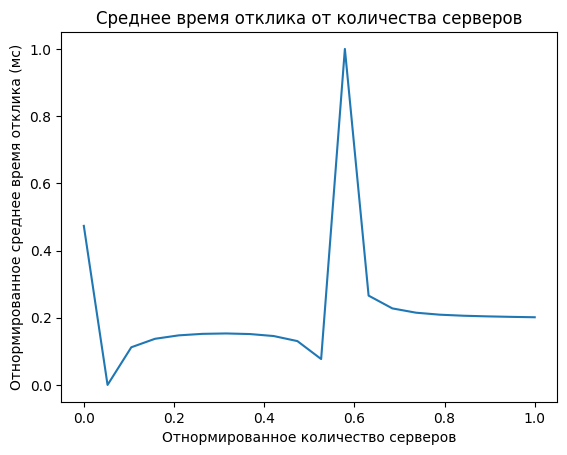

In [11]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Отнормированное среднее время отклика (мс)')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, normalized_response_times)

plt.show()

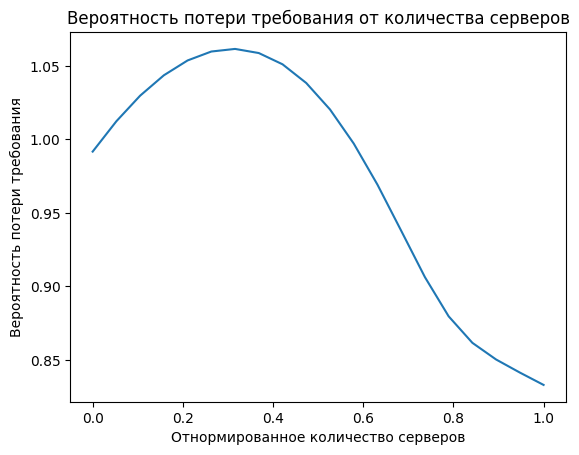

In [12]:
title = 'Вероятность потери требования от количества серверов'
        
plt.ylabel('Вероятность потери требования')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, loss_probabilities)

plt.show()

In [13]:
ideal_point = (0, 0, 0)
ideal_point_method_result = ideal_point_method(normalized_servers_num, normalized_response_times, loss_probabilities, (0, 0, 0))

optimal_index = np.argmin(ideal_point_method_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

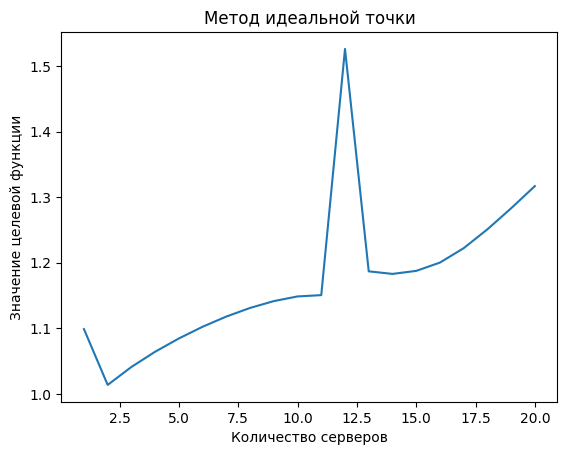

In [14]:
plt.title('Метод идеальной точки')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, ideal_point_method_result)

plt.show()

In [15]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 2
Время отклика: -2451.156546208322
Вероятность потери заявки: 1.012306191628133


In [16]:
weights = (0.1, 0.6, 0.3)

linear_convolution_result = linear_convolution(normalized_servers_num, normalized_response_times, loss_probabilities, weights)

optimal_index = np.argmin(linear_convolution_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

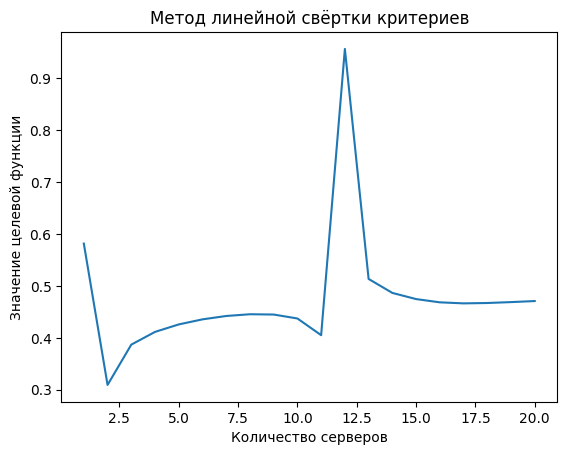

In [17]:
plt.title('Метод линейной свёртки критериев')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, linear_convolution_result)

plt.show()

In [18]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Среднее время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 2
Среднее время отклика: -2451.156546208322
Вероятность потери заявки: 1.012306191628133


In [19]:
for i in range(0, MAX_SERVERS, 1):
    print(i)
    print(loss_probabilities[i])

0
0.9916493276172661
1
1.012306191628133
2
1.0296828940501461
3
1.0435432601740946
4
1.0536378995637379
5
1.0597052794634874
6
1.061474286917865
7
1.0586696346218583
8
1.0510229141942602
9
1.0382953906754473
10
1.0203264109139498
11
0.9971399730145704
12
0.9691841688602876
13
0.9378448310815036
14
0.9062898984956267
15
0.8796342355254501
16
0.8616082314520271
17
0.8502692982934853
18
0.8413963698667164
19
0.8329905964742684
